In [ ]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-06-12
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

from Function.snn_IZHIlayers import *
from Function.snn_plot import *
from Function.snn_simulation import *
from Function.snn_stimulation import *
from Function.snn_receptive_field_weights import *

from line_profiler import LineProfiler

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the device to 'cpu'
device = 'cpu'
print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code

In [ ]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

single
torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_rf shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_rf shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_rf shape:  torch.Size([54, 54])
ra_intopn_rf shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([28, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([28, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([28, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([28, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn_intopn_rf sha

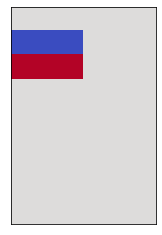

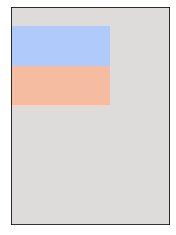

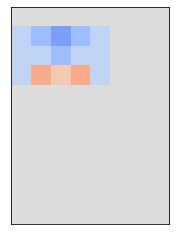

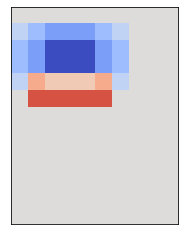

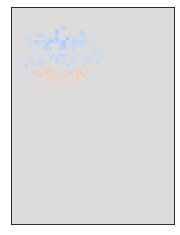

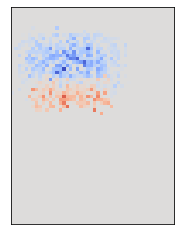

In [19]:
R = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output = 'single', plot_receptive_field = True)
# R.plot_receptive_field(sa_ind =0, ra_ind =0, no_legend = True)

In [ ]:
# Parameters
num_stim = 1000
pixel_h = 64
pixel_w = 48
F = 0.5
device = 'cpu'  # Or your device of choice

# Generate the stimuli and stack them up
stimulus = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

# Generate stimuli
for freq in range(1, 100, 10):  # Frequency from 1 to 100 with a step of 10
    # Convert the frequency to radians
    frequency_radians = 2 * np.pi * freq / num_stim
    print("Frequency:", freq, "Hz, which is", frequency_radians, "radians.")

    for i in range(num_stim):
        stim_dot = full_stim(F=F, pixel_h=pixel_h, pixel_w=pixel_w)
        
        # Apply sine wave form with the given frequency
        intensity = np.sin(frequency_radians * i)
        stimulus[:, :, i] = stim_dot * intensity  # Apply frequency code to stimulus

    S = SNN(R, device = device, noise_std_val = 0)
    S.feedforward(stimulus)
    mean_firing_rates = plot_SNN(S,layers=['sa','ra','cn'],plot_figure = True)

    plt.figure()
    plt.plot(stimulus[40, 40, :])
    plt.plot(torch.abs(torch.diff(stimulus[40, 40, :])) * 5)
    plt.title("Frequency: " + str(freq) + " Hz")
    plt.show()

    num_neurons = S.ra_spike_times[1].shape[0]

    # Initialize an array to hold the spike counts for each neuron
    spike_counts = np.zeros(num_neurons)

    # Calculate the spike count for each neuron
    for neuron in range(num_neurons):
        spike_counts[neuron] = np.count_nonzero(S.ra_spike_times[1][neuron, :])

    # Plot the spike counts
    plt.figure()
    plt.plot(range(num_neurons), spike_counts)
    plt.title("Spike Count per Neuron")
    plt.xlabel("Neuron Index")
    plt.ylabel("Spike Count")
    plt.show()


In [43]:
num_trials = 20
num_frequencies = range(80,100, 1)  # Frequencies from 1 to 100 with a step of 10
num_stim = 100
F = 0.5  # Changed from 10 to 0.02 to match the frequency stimulation example
pixel_h = 64
pixel_w = 48
intensity = 20
device = 'cpu'  # Or your device of choice
data = []
labels = []
data_SC = []
data_SC_RA = []  # Spike counts for RA
data_SC_SA = []  # Spike counts for SA
data_SC_total = []  # Combined spike counts

# Run the trials
for trial in range(num_trials):
    # Generate the stimuli for each frequency
    for frequency in num_frequencies:
        print(f"Trial: {trial}, Frequency: {frequency} Hz")

        # Generate the stimulus
        stimulus = generate_single_frequency_stimulation(frequency, num_stim=num_stim, pixel_h=pixel_h, pixel_w=pixel_w, F=F, device=device)

        S = SNN(R, device = device, noise_std_val = 2)
        S.feedforward(stimulus)
        mean_firing_rates = plot_SNN(S, plot_figure=False)

        num_neurons = S.ra_spike_times[2].shape[0]
        spike_counts_RA = np.zeros(num_neurons)
        for neuron in range(num_neurons):
            spike_counts_RA[neuron] = np.count_nonzero(S.ra_spike_times[2][neuron, :])

        num_neurons = S.sa_spike_times[2].shape[0]
        spike_counts_SA = np.zeros(num_neurons)
        for neuron in range(num_neurons):
            spike_counts_SA[neuron] = np.count_nonzero(S.sa_spike_times[2][neuron, :])


        # Combine the spike counts
        spike_counts_total = np.concatenate([spike_counts_RA, spike_counts_SA])

        # Save the data and labels
        data.append(mean_firing_rates.cpu().numpy())
        data_SC_RA.append(spike_counts_RA)
        data_SC_SA.append(spike_counts_SA)
        data_SC_total.append(spike_counts_total)
        labels.append(frequency)





print(labels)

Trial: 0, Frequency: 80 Hz
Trial: 0, Frequency: 81 Hz
Trial: 0, Frequency: 82 Hz
Trial: 0, Frequency: 83 Hz
Trial: 0, Frequency: 84 Hz
Trial: 0, Frequency: 85 Hz
Trial: 0, Frequency: 86 Hz
Trial: 0, Frequency: 87 Hz
Trial: 0, Frequency: 88 Hz
Trial: 0, Frequency: 89 Hz
Trial: 0, Frequency: 90 Hz
Trial: 0, Frequency: 91 Hz
Trial: 0, Frequency: 92 Hz
Trial: 0, Frequency: 93 Hz
Trial: 0, Frequency: 94 Hz
Trial: 0, Frequency: 95 Hz
Trial: 0, Frequency: 96 Hz
Trial: 0, Frequency: 97 Hz
Trial: 0, Frequency: 98 Hz
Trial: 0, Frequency: 99 Hz
Trial: 1, Frequency: 80 Hz
Trial: 1, Frequency: 81 Hz
Trial: 1, Frequency: 82 Hz
Trial: 1, Frequency: 83 Hz
Trial: 1, Frequency: 84 Hz
Trial: 1, Frequency: 85 Hz
Trial: 1, Frequency: 86 Hz
Trial: 1, Frequency: 87 Hz
Trial: 1, Frequency: 88 Hz
Trial: 1, Frequency: 89 Hz
Trial: 1, Frequency: 90 Hz
Trial: 1, Frequency: 91 Hz
Trial: 1, Frequency: 92 Hz
Trial: 1, Frequency: 93 Hz
Trial: 1, Frequency: 94 Hz
Trial: 1, Frequency: 95 Hz
Trial: 1, Frequency: 96 Hz
T

In [44]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

# Assuming your labels and data arrays are defined as follows:
data_RA = np.array(data_SC_RA)
data_SA = np.array(data_SC_SA)
data_total = np.array(data_SC_total)
labels = np.array(labels)

# Datasets
datasets = {
    'RA': data_RA,
    'SA': data_SA,
    'Total': data_total
}

# Loop over the datasets and apply SVM
for name, data in datasets.items():
    print(f"\n{name} data:")
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Create and train the SVM
    clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
    clf.fit(X_train, y_train)

    # Test the SVM
    y_pred = clf.predict(X_test)

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, y_pred))

    misclassified = np.where(y_test != y_pred)

    # Print the misclassified labels
    print("Misclassified labels: ", y_test[misclassified])
    print("Test output of misclassified labels: ", y_pred[misclassified])

    # Print the indices of the misclassified samples
    # print("Indices of misclassified samples: ", misclassified)



RA data:
Accuracy: 0.9
Misclassified labels:  [85 92 81 81 82 81 84 80]
Test output of misclassified labels:  [86 93 80 80 83 80 85 81]

SA data:
Accuracy: 0.275
Misclassified labels:  [89 80 90 84 89 94 86 86 89 81 92 82 96 91 85 97 95 91 80 96 85 82 84 93
 81 97 82 81 81 95 85 82 82 88 81 82 93 86 81 98 90 94 90 84 98 81 92 94
 93 80 80 85 85 88 86 87 96 89]
Test output of misclassified labels:  [87 83 89 83 86 95 84 83 90 84 91 83 98 90 86 96 99 92 83 98 88 85 83 92
 83 99 83 83 83 94 83 83 83 85 83 83 92 85 83 97 89 97 88 85 96 83 90 95
 94 83 83 86 83 84 87 84 95 90]

Total data:
Accuracy: 0.9
Misclassified labels:  [85 92 81 81 82 81 84 80]
Test output of misclassified labels:  [86 93 80 80 83 80 85 81]


In [ ]:
# Convert data and labels to numpy arrays

data = np.array(data)
labels = np.array(labels)
print(labels)
# np.save('data_svm_frequency.npy', data)
# np.save('labels_frequency.npy', labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create and train the SVM
clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
clf.fit(X_train, y_train)

# Test the SVM
y_pred = clf.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

print(X_train.shape)
print(X_test.shape)
print(y_train)
print(y_test)

misclassified = np.where(y_test != y_pred)

# Print the misclassified labels
print("Misclassified labels: ", y_test[misclassified])

# Print the indices of the misclassified samples
print("Indices of misclassified samples: ", misclassified)

In [ ]:
# Convert data and labels to numpy arrays

data = np.array(data_SC)
labels = np.array(labels)
print(labels)
# np.save('data_svm_frequency.npy', data)
# np.save('labels_frequency.npy', labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create and train the SVM
clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
clf.fit(X_train, y_train)

# Test the SVM
y_pred = clf.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

print(X_train.shape)
print(X_test.shape)
print(y_train)
print(y_test)

misclassified = np.where(y_test != y_pred)

# Print the misclassified labels
print("Misclassified labels: ", y_test[misclassified])

# Print the indices of the misclassified samples
print("Indices of misclassified samples: ", misclassified)